We've done two runs in the Ha range: one with a radius 10x our NGC5548 model.
Comparing the spectra for them:

/Users/amsys/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


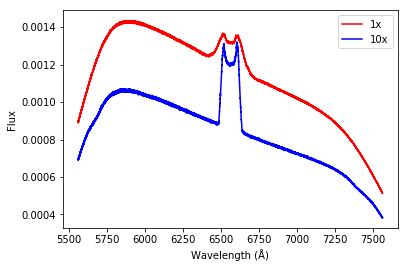

In [72]:
%matplotlib inline

import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

os.chdir('/Users/amsys/paper_cloudy')

r10 = 'l100_rad10'
r01 = 'l100_rad01'

spec_r01 = Table.read(r01+'.spec', format='ascii')
spec_r10 = Table.read(r10+'.spec', format='ascii')
fig, ax = plt.subplots()
ax.set_xlabel("Wavelength (Å)")
ax.set_ylabel("Flux")
ax.plot(spec_r01['Lambda'], spec_r01['A40P0.50'], 'r', label='1x')
ax.plot(spec_r10['Lambda'], spec_r10['A40P0.50'], 'b', label='10x')
ax.legend()
fig.show()

We get a **much** stronger line in the 10x radius model, with a vastly improved line-continuum ratio. The dips at the edge of the spectrum are a feature of our binning in the model; we have no photons generated beyond the <5500/>7500 bounds, so none can be up/down scattered from there into our spectrum.

Plotting the distribution of C-IV and H-I species throughout the wind:

/Users/amsys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/Users/amsys/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


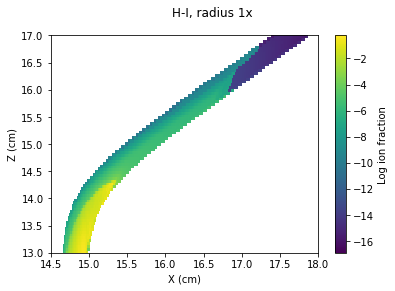

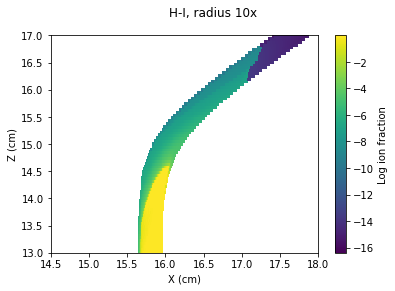

In [106]:
import matplotlib.colors as colors

def load_grid(prefix):
    return [np.loadtxt(prefix+'.grid_x.txt'),
            np.loadtxt(prefix+'.grid_z.txt')]

x_r01, z_r01 = load_grid(r01+'.dom0')
x_r10, z_r10 = load_grid(r10+'.dom')

table_h1_r01 = Table.read(r01+'.ionH1.dat', format='ascii')
table_h1_r10 = Table.read(r10+'.ionH1.dat', format='ascii')

def plot_dat(table, x, z, title):
    fig, ax = plt.subplots() 
    fig.suptitle(title)
    ax.set_xlabel('X (cm)')
    ax.set_ylabel('Z (cm)')
    
    size = (len(x)-1, len(z)-1)
    data = np.reshape(table['var'], size).T
    
    im = ax.pcolormesh(np.log10(x), np.log10(z), np.ma.log10(data))
    ax.set_xlim(14.5, 18)
    ax.set_ylim(13, 17)
    cbar = fig.colorbar(im, ax=ax).set_label('Log ion fraction')
    fig.show()
    
    
plot_dat(table_h1_r01, x_r01, z_r01, 'H-I, radius 1x')
plot_dat(table_h1_r10, x_r10, z_r10, 'H-I, radius 10x')

Neatly, we don't seem to see any change in the extended wind behaviour- everything at or greater than ~1e14.5cm height is more or less equivalent. The transition zone from wind base to extended wind is roughly consistent. We also see a much greater ion fraction of H-1 in the base.

/Users/amsys/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/Users/amsys/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


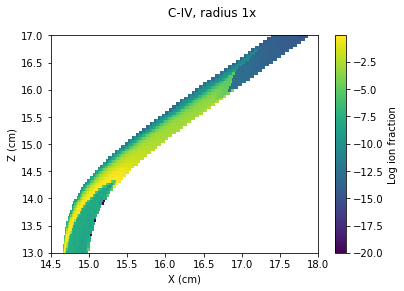

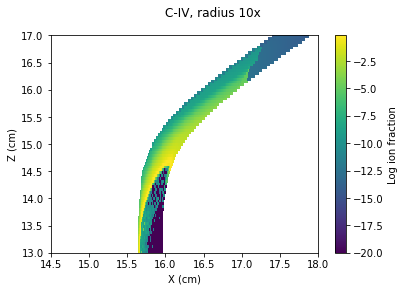

In [107]:
table_c4_r01 = Table.read(r01+'.ionC4.dat', format='ascii')
table_c4_r10 = Table.read(r10+'.ionC4.dat', format='ascii')

plot_dat(table_c4_r01, x_r01, z_r01, 'C-IV, radius 1x')
plot_dat(table_c4_r10, x_r10, z_r10, 'C-IV, radius 10x')

For C-IV, the situation is more or less the same in terms of ion distribution. Emission still occurs at roughly the same height above the disk, just at a later radius, the extended wind region is still roughly similar and peters out at the same radius. There's less C-IV in the base but the front seems sharper to compensate.

Next steps are:
* Do another run with a full spectrum to see if the line-continuum improvements are just a Ha thing and the rest of the spectrum is wrecked, or if it's an all-round good thing
* Bin the Ha photons and verify that we're expecting an OOM increase in path
* Do all this sort of analysis in Jupyter Notebooks stored on GitHub in future so I don't have to root around three different machines for the python & gnuplot scripts used to make figures